# LTEM Image Simulation Example Notebook
This notebook gives examples of how to simulate and reconstruct Lorentz transmission electron microscopy (LTEM) images from a given magnetization over a 3D region. This notebook is part of the PyLorentz codebase for analyzing LTEM data. For background on LTEM and PyLorentz, please refer to our [documentation pages](https://pylorentztem.readthedocs.io/en/latest/). 

We demonstrate two examples in this notebook. In both cases we are using an input magnetization configuration that is generated using the [MuMax3](http://mumax.github.io/) package. The first example is for an artificial spin ice (ASI), and the second is for a Néel skyrmion. 

There are 3 main steps for simulating an LTEM image: 
1. Generate the magnetization configuration (not covered here)
2. Calculate the phase shift 
3. Simulate the LTEM images from the phase shift
4. Optionally reconstruct the integrated magnetic induction

If you have not yet worked through the TIE_template notebook we recommend you do so first, as the TIE reconstruction method will used here as well. 

Authors: Arthur McCray  
v2.0, LBL/ANL, July 2024  


The example data used for all demo notebooks can be [downloaded here](https://zenodo.com). The demo notebooks expect the downloaded files to be unzipped and placed in PyLorentz/Examples/data. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from PyLorentz.phase import TIE, SITIE
from PyLorentz.sim import SimLTEM
from PyLorentz.utils import Microscope
from PyLorentz.visualize import show_im, show_2D
import matplotlib.pyplot as plt
import numpy as np

# ASI demo

### Materials Parameters
The micromagnetics output file contains the vector magnetization information, as well as voxel (3D pixel) size and physical dimensions of the sample. It does not, however, provide any material information of the sample itself that is required for the simulation. Additionally, many samples will be on a substrate or membrane of some sort which we can account for while assuming it is of uniform thickness. The parameters relevant for electron microscopy, namely the mean inner potential and extinction distance, can occasionally be found for single elements in electron microscopy textbooks (such as Reimer & Kohl). 

The following material parameters are used: 
* `B0`: The saturation induction in gauss. 
* `sample_V0`: The sample mean inner potential in volts. 
* `sample_xip0`: The extinction distance for the sample in nm. 
* `mem_thickness`: The thickness of the sample membrane in nm. 
* `mem_xip0`: The extinction distance for the membrane in nm. 


The magnetization configuration itself is read from a `.ovf` file, which in this case is the output from a [MuMax3](http://mumax.github.io/) simulation. The example data is for a small region of permalloy artificial spin ice (ASI). The simulation area is a grid of size (1,500,500) with cubic voxels of length 5nm. 

The magnetization file, along with the relevant material parameters, is given to a `SimLTEM` object which handles the simulation steps. 

Text file found: d:\code\PyLorentz\Examples\data\square_ASI_mumax.ovf
Simulation size (z, y, x) : (1, 500, 500)
Image scale : 5 nm/pixel.


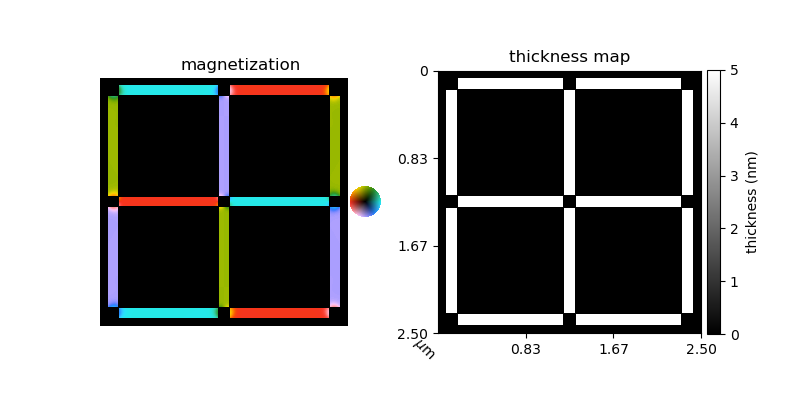

In [30]:
ovf_file = "./data/square_ASI_mumax.ovf"
simulator = SimLTEM.load_ovf(ovf_file)
simulator.visualize(xy_only=True)

sample_params = {
    "B0" : 1e4, # gauss
    "sample_V0" : 20, # V
    "sample_xip0" : 50, # nm
    "mem_thickness" : 50, # nm
    "mem_xip0" : 1000, # nm
}
beam_energy = 200e3 # eV

simulator.set_sample_params(sample_params)
simulator.beam_energy = beam_energy

## Phase shift calculation
There are two main methods for calculating the magnetic component of the electron phase shift through the sample. The first is the Mansuripur algorithm, which is an established technique based on [this paper by Mansuripur](https://doi.org/10.1063/1.348682). The method is efficient, but it is only accurate for 2D magnetization configurations (uniform along the beam direction) and when imaged perpendicular to the sample. In this example, we are imaging the sample without tilt and it is therefore the fastest and best method to use. 

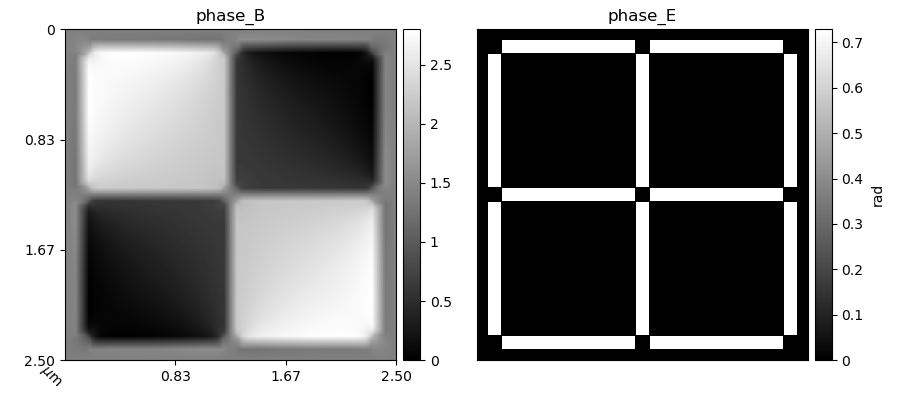

In [4]:
phase_method = "mansuripur" ## "mansuripur" or "linsup"
tilt_x = 0 # degrees
tilt_y = 0 # degrees

simulator.compute_phase(
    method = phase_method,
    tilt_y = tilt_y,
    tilt_x = tilt_x,
    # padded_shape=(1024, 1024), # make it set a attribute so consistent for sim images
)
simulator.show_phase()

### Imaging conditions
Once the phase shift is calculated, LTEM images can be simulated using a `Microscope` object, for which individual aberrations can be defined. Here we demonstrate simulating a 5-image TFS with defocii magnitudes of 50 um and 1 mm. Because this sample has non-uniform thickness and induces a non-uniform electrostatic phase shift, we simulate both a normal (unflip) TFS as well as a flip TFS. 

We also add some random electrostatic phase shift to simulate the effect of an amorphous sample membrane. This is a unitless scaling parameter which can be increased or omitted with the default 0 value. 


Creating a new microscope object with the following properties:
Quantities preceded by a star (*) can be changed using optional arguments at call.
--------------------------------------------------------------
*Accelerating voltage        [V]         E:         2e+05
*Spherical Aberration        [nm]        Cs:        2e+05
*Chromatic Aberration        [nm]        Cc:        5e+06
*Beam Coherence              [rad]       theta_c:   1e-05
*2-fold astigmatism          [nm]        Ca:          0
*2-fold astigmatism angle    [rad]       phi_a:       0
*defocus spread              [nm]        def_spr:    80
Electron wavelength          [nm]        lambda:    0.002508
Relativistic factor          [-]         gamma:     1.391
Interaction constant         [1/V/nm]    sigma:     0.007288
--------------------------------------------------------------

Simulating images for defocus values: -1 mm, -50 um, 0 nm, 50 um, 1 mm
Will simulate a tfs for both unflip and flip orientations.


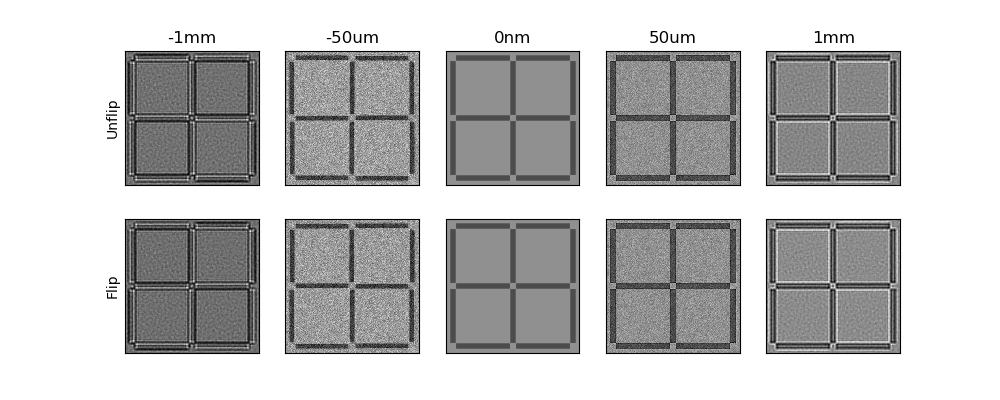

In [5]:
scope = Microscope(
    E=beam_energy,
    Cs=200e3,
    theta_c=0.01e-3,
    def_spr=80,
    verbose=True,
)


defvals = [1e6, 5e4]
tfs = simulator.sim_TFS(
    defocus_values=defvals,
    scope=scope,
    amorphous_bkg=300,
    flip = True,
)
tfs.show_tfs()


### TIE reconstruction
Lastly we can simulate the TIE reconstructed integrated induction from the images we have simulated. This is identical to the TIE demonstration notebook. 

Performing TIE reconstruction with defocus ± 1 mm, index = 1
Reconstructing with two TFS flip/unflip to seperate phase_B and phase_E


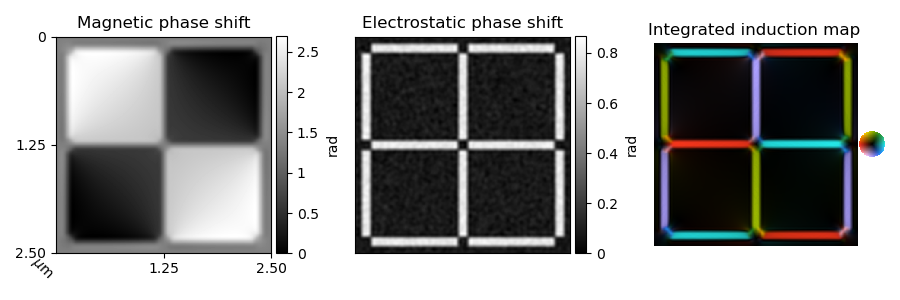

In [6]:
tie = TIE(tfs)
tie.reconstruct(
    index=1,
)
tie.visualize(cbar=True)

Unsurprisingly, in this idealized and noise-free case, our reconstructed magnetic phase shift is very good. 

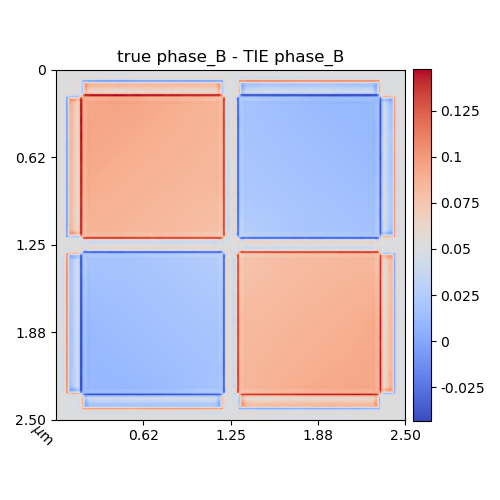

In [7]:
show_im(simulator.phase_B- tie.phase_B, title="true phase_B - TIE phase_B", scale=tie.scale, cmap='diverging')

We can also test to see what would happen if we tried to perform a TIE reconstruction without using a flip TFS. We see that the total phase shift is reconstructed (phase_B + phase_E) which creates artifacts in the integrated induction map. 

Performing TIE reconstruction with defocus ± 1 mm, index = 1
Reconstructing with a single TFS


d:\code\pylorentz\PyLorentz\phase\tie.py:311: UserWarning:Setting flip=False even though dataset has flip/unflip tfs


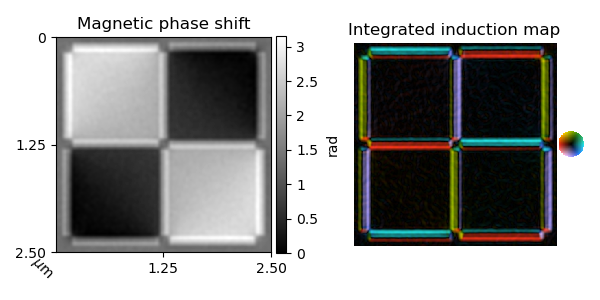

In [8]:
tie.flip = False
tie.reconstruct(
    index=1,
)
tie.visualize(cbar=True)

# Néel skyrmion demo

In this example we simulate a tilted Néel skyrmion using the [linear superposition method](https://doi.org/10.1103/PhysRevApplied.15.044025). It also highlights how the magnetization, i.e. the output of a micromagnetics simulation, is _not_ what you will observe in the microscope. The microscope measures (and we visualize with phase reconstruction) the integrated magnetic induction along the beam direction. This can look very different from the magnetization. 

We will perform two phase reconstructions using the Mansuripur algorithm and linear superposition method in order to compare the two. 

Text file found: d:\code\PyLorentz\Examples\data\Neel_skyrmion_mumax.ovf
Simulation size (z, y, x) : (8, 128, 128)
Image scale : 2 nm/pixel.


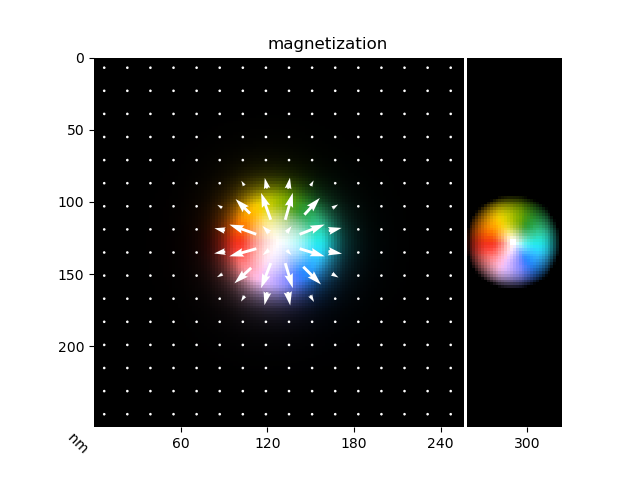

In [9]:
skyrm_ovf_file = "./data/Neel_skyrmion_mumax.ovf"
sim_linsup = SimLTEM.load_ovf(skyrm_ovf_file)
sim_mans = SimLTEM.load_ovf(skyrm_ovf_file, verbose=0)
sim_mans.show_mags(num_arrows=16, arrow_size=10, arrow_width=1, show_scale=True)

### Simulation parameters
A Neel skyrmion must be tilted in the microscope in order to induce a phase shift. Due to the perspective change when tilting, the edge of the sample and membrane will become visible and create strong contrast. To remove this, and because we don't care about the membrane beyond the additional amorphous background it contributes (which we add later), we set the membrane_thickness to 0. We also assume that our sample is of uniform thickness well outside the field-of-view that we are imaging, and we therefore set sample_v0 to be 0 so that we do not simulate the electrostatic phase shift and see the edge of our sample. 

When simulating tilted samples we generally recommend setting membrane thickness to 0 (the default value), and additionally setting sample_V0 to 0 when not simulating patterned structures. 

In [10]:
tilt_x = 30 # degrees
tilt_y = 0 # degrees
beam_energy = 200e3 # eV

sample_params = {
    "B0" : 7.3e3, # gauss
    "sample_xip0" : 50, # nm
    "sample_V0" : 0, # setting to 0 because uniform thickness and will be tilting
    "membrane_thickness": 0, # nm
}

sim_mans.set_sample_params(sample_params)
sim_linsup.set_sample_params(sample_params)


We next compute the phase shifts. While the Mansuripur algorithm is very fast, running sim_linsup is generally quite slow. If your device has a GPU, you can use it to speed up the calculation by setting device="gpu". If you do not have a GPU, multiprocessing will be used on the cpu. Reconstructing this example data on my laptop: linsup runs in ~3.8 seconds on GPU, ~6.8 seconds on CPU with multiprocessing, and ~1:10 on cpu with multiproc=False. The Mansuripur algorithm, by contrast, took ~2.4 ms. 

Linsup scales linearly with the magnetization size in `z` but vaguely quadratically with `x` and `y`. For example, calculating a (2, 256, 256) volume (same number of voxels) takes ~13.7 seconds with the GPU on my laptop. However, linsup can still be viable for very large patterned structures, as it scales linearly with the number of pixels in the shape function. The ASI demo file, which is 1x500x500, runs in ~95 seconds because only 20% of the cells in the total volume are used. When running with GPU, the `batch_size` is approximated based on input size and total GPU memory, but the user can set the batch_size directly for further optimization. 

In [11]:
sim_mans.compute_phase(
    method = "mansuripur",
    tilt_x = tilt_x,
    tilt_y = tilt_y,
    beam_energy=beam_energy,
)

sim_linsup.compute_phase(
    method = "linsup",
    tilt_x = tilt_x,
    tilt_y = tilt_y,
    beam_energy=beam_energy,
    device="gpu", # comment out this line if no gpu
)

Beginning linsup phase calculation for 131072 voxels.
Running on GPU with batch_size = 4093
total time: 3.5195 sec, 2.6852e-05 sec/voxel.


The phase_B calculated by the Mansuripur and linsup methods are identical when `tilt_x == tilt_y == 0`, but the Mansuripur phase shift is only an approximation otherwise. Importantly, only the linsup phase shift shows the appropriate perspective shift that occurs when tilting the sample. 

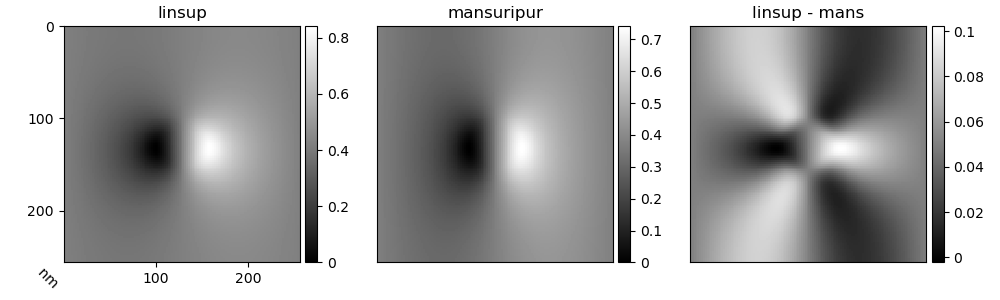

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(10,3))
show_im(sim_linsup.phase_B, figax=(fig, axs[0]), title="linsup", scale=sim_linsup.scale)
show_im(sim_mans.phase_B, figax=(fig, axs[1]), title="mansuripur", ticks_off=True)
show_im(sim_linsup.phase_B-sim_mans.phase_B, figax=(fig, axs[2]), title="linsup - mans", ticks_off=True)
plt.tight_layout()
plt.show()

We next simulate LTEM images from the phase shift. Here we show simulating one or more defocus values rather than a full TFS. 

Simulating images for defocus values: -100 um


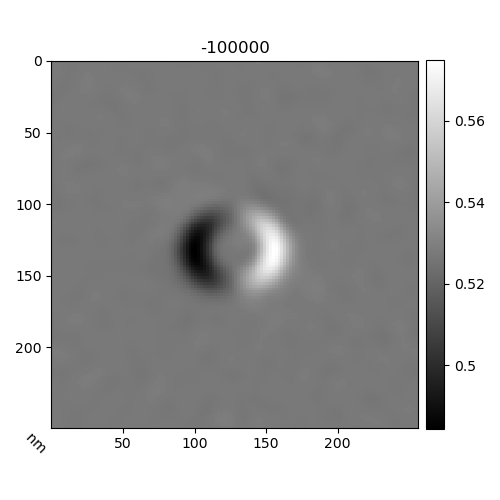

In [15]:
scope = Microscope(
    E=beam_energy,
    Cs=200e3,
    theta_c=0.01e-3,
    def_spr=80,
)

defvals = [-100_000] # list of one or multiple defocus values
dd = sim_linsup.sim_images(
    defocus_values=defvals,
    scope=scope,
    amorphous_bkg=True,
)


### plotting
ims = dd.images
if len(defvals) > 1:
    fig, axs = plt.subplots(ncols=len(defvals), figsize=(3*len(defvals), 3))
    vmin, vmax = ims.min(), ims.max()
    for i, im in enumerate(ims):
        show_im(im, figax=(fig,axs[i]), cbar=False, ticks_off=True, title=defvals[i], vmin=vmin, vmax=vmax, scale=sim_linsup.scale)
else:
    show_im(ims, title=defvals[0], scale=sim_linsup.scale)

In order to perform phase reconstruction, we load the image into a SITIE object. We can either provide the Defocused_Dataset directly (which contains the image and all metadata), or provide just the image array and specify the metadata manually. 

Performing SITIE reconstruction with defocus -100 um, index = 0


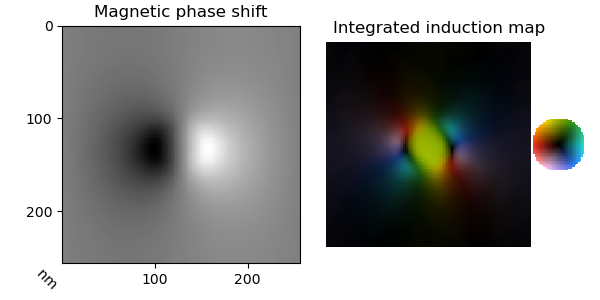

In [16]:
sitie = SITIE(
    dd=dd,
    save_dir="./data/Neel_sims",
)

### equivalently, we could do:
# s = sitie.from_array(
#     image = dd.images[0],
#     scale = dd.scale,
#     defvals = dd.defvals[0],
#     beam_energy = dd.beam_energy,
#     simulated = True,
# )

sitie.reconstruct(
    # index=0, # default 0
    # save=True,
).visualize();

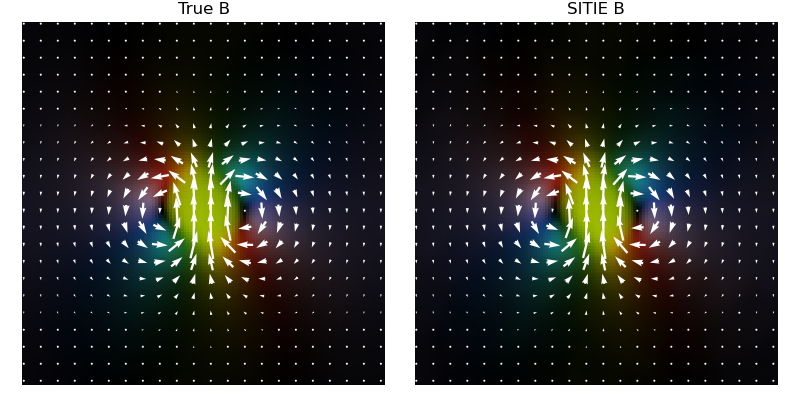

In [28]:
(true_By, true_Bx) = sitie.induction_from_phase(sim_linsup.phase_B)
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
show_2D(true_Bx, true_By, rad=0, num_arrows=24, arrow_width=0.8, arrow_size=1, title="True B", figax=(fig, axs[0]))
show_2D(sitie.Bx, sitie.By, rad=0, num_arrows=24, arrow_width=0.8, arrow_size=1, title="SITIE B", figax=(fig, axs[1]))
plt.tight_layout()
plt.show()

--- End Notebook ---